## Univariate correlation at the individual metabolite level using Kendall’s Tau 

load libraries

In [1]:
library(beeswarm)
library(ggplot2)

load blank filtered feature table

In [2]:
ft <- read.csv('../../featuretable_blankfiltered.tsv', sep = '\t', check.names = F)

In [36]:
dim(ft)

[1]  148 6053

load metadata

In [4]:
md <- read.table('../../metadata.tsv', sep = '\t', header = T)

In [37]:
dim(md)

[1] 148  14

are there any features with all zeros?

In [6]:
length(which(rowSums(ft[,2:ncol(ft)]) == 0))

[1] 0

transpose feature table for correlation analysis

In [7]:
ft <- as.data.frame(t(ft))
colnames(ft) <- ft[1,]
ft <- ft[-1,]

match metadata with feature table and bring filenames in same order (this should return TRUE)

In [9]:
md <- md[which(md$filename %in% rownames(ft)),]
md <- md[match(rownames(ft),md$filename),]
identical(as.character(md$filename),as.character(rownames(ft)))

[1] TRUE

select metadata category for correlation analysis

In [10]:
catscont <- md$ATTRIBUTE_Gestationsalder

how many samples are there per gestational age?

In [11]:
table(catscont)

catscont
28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 
10 10  8 10 10 10 10 10 10 10 10 10 10 10 10 

normalize feature table by total ion current (TIC)

In [12]:
ftt <- t(apply(ft, 1, function(x) (x)/sum((x))))

assess correlation for one metabolite

In [14]:
cor.test(catscont, scale(ftt[,2])[,1], method = 'kendall')


	Kendall's rank correlation tau

data:  catscont and scale(ftt[, 2])[, 1]
z = 2.4266, p-value = 0.01524
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.1384691 


assess correlation for all metabolites and adjust p-values for multiple hypothesis testing

In [15]:
corres <- t(sapply(1:ncol(ftt), function(x) unlist(cor.test(catscont, scale(ftt[,x])[,1], method = 'kendall')[c("estimate", "p.value")])))
corres <- cbind(corres,p.adjust(corres[,2], method = "fdr"))

In [16]:
rownames(corres) <- colnames(ftt)
corres <- cbind(corres,rownames(corres))
colnames(corres) <- c('estimate.cor','p.value','p.value.corrected','cluster id')

In [17]:
head(corres)

estimate.cor,p.value,p.value.corrected,cluster id
0.148332656151525,0.00933651479729077,0.0661755551147553,1
0.138469103568559,0.0152400223091763,0.0928981420316659,2
0.136382582829855,0.0168456719471723,0.0986139770756616,3
0.130312704317261,0.0223899737855434,0.117883843888379,4
0.0422994658846421,0.4585213165765,0.692645253116435,5
0.0474209258796436,0.40595342166953,0.651594905855909,6


save correlation coefficients and p-values to file for import into Cytoscape

In [18]:
write.table(corres, 'KendallsTauCorrelation_GA.txt', sep = '\t', quote = F, row.names = F)

how many features are significantly correlated with gestational age after FDR correction?

In [19]:
corressig <- corres[which(as.numeric(corres[,3]) < 0.05),]
corressig <- corressig[order(corressig[,1]),]

In [20]:
dim(corressig)
nrow(corressig)/ncol(ft)

[1] 744   4

[1] 0.1229143

In [21]:
head(corressig)

,estimate.cor,p.value,p.value.corrected,cluster id
1383,-0.156868422809861,0.0059765290239984,0.0489525442249829,1383
895,-0.157437473920417,0.00579716584055939,0.0478068730693542,895
2342,-0.158028317531598,0.00562244050675711,0.046556268655815,2342
7694,-0.158913776493351,0.0060860094125607,0.0497147300596895,7694
3657,-0.159144627252084,0.00528782405165934,0.0447653132653063,3657
33,-0.159334310955602,0.00523380135717488,0.0444322575245155,33


### Plot results and match back to spectral library hits

load GNPS spectral library data

In [22]:
libids <- read.table('GNPSLibraryHits.tsv', sep = '\t', header = T, quote = '', comment.char = "", check.names = F)

In [23]:
head(libids)
dim(libids)

#Scan#,Adduct,CAS_Number,Charge,Compound_Name,Compound_Source,Data_Collector,ExactMass,FileScanUniqueID,INCHI,⋯,RT_Query,SharedPeaks,Smiles,SpecCharge,SpecMZ,SpectrumFile,SpectrumID,TIC_Query,UpdateWorkflowName,tags
<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,⋯,<int>,<int>,<fct>,<int>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>
100,M+H,104983,1,Spectral Match to 4-Imidazoleacrylic acid from NIST14,Isolated,Data deposited by lfnothias,0.000,spectra/specs_ms.mgf100,N/A,⋯,0,5,N/A,1,139.050,spectra/specs_ms.mgf,CCMSLIB00003136584,23420000,UPDATE-SINGLE-ANNOTATED-BRONZE,
10001,M+H,20902458,1,Spectral Match to Penicillamine disulfide from NIST14,Isolated,Data deposited by amelnik,0.000,spectra/specs_ms.mgf10001,N/A,⋯,0,8,N/A,1,297.093,spectra/specs_ms.mgf,CCMSLIB00003137618,70327000,UPDATE-SINGLE-ANNOTATED-BRONZE,
101,M+H,81130,1,Spectral Match to Dexpanthenol from NIST14,Isolated,Data deposited by daniel,0.000,spectra/specs_ms.mgf101,N/A,⋯,0,7,N/A,1,206.139,spectra/specs_ms.mgf,CCMSLIB00003135881,46390000,UPDATE-SINGLE-ANNOTATED-BRONZE,
10153,[M+H]+,979-92-0,1,Massbank:PR100198 S-Adenosyl-L-homocysteine|AdoHcy|S-Adenosylhomocysteine|5'-Deoxy-S-adenosyl-L-homocysteine|S-(5'-Deoxyadenosine-5')-L-homocysteine|Formycinylhomocysteine,Isolated,Massbank,0.000,spectra/specs_ms.mgf10153,"1S/C14H20N6O5S/c15-6(14(23)24)1-2-26-3-7-9(21)10(22)13(25-7)20-5-19-8-11(16)17-4-18-12(8)20/h4-7,9-10,13,21-22H,1-3,15H2,(H,23,24)(H2,16,17,18)/t6-,7+,9+,10+,13+/m0/s1",⋯,0,4,OC(=O)[C@@H](N)CCSC[C@@H](O1)[C@@H](O)[C@@H](O)[C@@H]1n(c3)c(n2)c(n3)c(N)nc2,1,385.129,spectra/specs_ms.mgf,CCMSLIB00000223026,675400,UPDATE-SINGLE-ANNOTATED-BRONZE,
10253,Cat,752166395,1,Spectral Match to Hemin cation from NIST14,Isolated,Data deposited by t3hdon,0.000,spectra/specs_ms.mgf10253,N/A,⋯,0,6,N/A,1,616.177,spectra/specs_ms.mgf,CCMSLIB00003136854,6482000,UPDATE-SINGLE-ANNOTATED-BRONZE,
10334,M-H2O+H,?81-24-3,1,taurocholic acid,commercial,A. Jarmusch,515.292,spectra/specs_ms.mgf10334,"1S/C26H45NO7S/c1-15(4-7-23(31)27-10-11-35(32,33)34)18-5-6-19-24-20(14-22(30)26(18,19)3)25(2)9-8-17(28)12-16(25)13-21(24)29/h15-22,24,28-30H,4-14H2,1-3H3,(H,27,31)(H,32,33,34)/t15?,16-,17+,18+,19-,20-,21+,22-,24-,25?,26?/m0/s1",⋯,0,16,C[C@H](CCC(=O)NCCS(=O)(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[C@H]3[C@H]2[C@@H](C[C@H]4[C@@]3(CC[C@H](C4)O)C)O)O)C,1,498.288,spectra/specs_ms.mgf,CCMSLIB00005435562,1374900,UPDATE-SINGLE-ANNOTATED-GOLD,


[1] 206  36

match correlation results to spectral library hits

In [24]:
correslib <- cbind(corres, as.character(libids$Compound_Name[match(corres[,4],libids$`#Scan#`)]))

In [25]:
head(correslib)

estimate.cor,p.value,p.value.corrected,cluster id,
0.148332656151525,0.00933651479729077,0.0661755551147553,1,NA
0.138469103568559,0.0152400223091763,0.0928981420316659,2,NA
0.136382582829855,0.0168456719471723,0.0986139770756616,3,NA
0.130312704317261,0.0223899737855434,0.117883843888379,4,NA
0.0422994658846421,0.4585213165765,0.692645253116435,5,CREATINE
0.0474209258796436,0.40595342166953,0.651594905855909,6,NA


how many features correlating significantly with gestational age (FDR adjusted p-value < 0.05) do have a spectral library match?

In [26]:
sigs <- correslib[which(as.numeric(corres[,3]) < 0.05),]

In [27]:
dim(sigs)

[1] 744   5

In [28]:
sigs[which(sigs[,5]!= 'NA'),]
dim(sigs[which(sigs[,5]!= 'NA'),])

,estimate.cor,p.value,p.value.corrected,cluster id,
33,-0.159334310955602,0.00523380135717488,0.0444322575245155,33,"Massbank:PB000483 Spermidine|N-(3-aminopropyl)butane-1,4-diamine"
36,0.346741810031954,1.22808311277163e-09,1.00453879481171e-07,36,Spectral Match to Betaine from NIST14
65,-0.205996502021172,0.000306174115258615,0.00531023472682063,65,"Massbank:EA030311 Caffeine|1,3,7-trimethyl-3,7-dihydro-1H-purine-2,6-dione|1,3,7-trimethylpurine-2,6-dione"
78,0.158765259845047,0.00539738301921214,0.0453754991879043,78,Glutamic acid
92,-0.278645360468786,1.04395809714914e-06,4.15728839608141e-05,92,Spermine
100,0.411234269228269,5.73063457139175e-13,1.02022150178336e-10,100,Spectral Match to 4-Imidazoleacrylic acid from NIST14
109,0.329290909308245,7.89371001079464e-09,4.97714861409792e-07,109,Glutamine
214,0.362485557423996,2.11929630666044e-10,2.13801675736928e-08,214,OPHTHALMIC ACID
493,0.195753582031169,0.000602435188327556,0.00878684384324505,493,"""NEPSILON,NEPSILON,NEPSILON-TRIMETHYLLYSINE"""
511,0.362864924831033,2.02958125083275e-10,2.08221276462553e-08,511,Spectral Match to L-Histidine from METLIN


[1] 40  5

### Visualize results as box plots

plot a single feature

In [29]:
ftplot <- ftt

In [30]:
selid <- '92'

In [31]:
corres[corres[,4] == as.numeric(selid),]

estimate.cor                p.value      p.value.corrected 
  "-0.278645360468786" "1.04395809714914e-06" "4.15728839608141e-05" 
            cluster id 
                  "92"

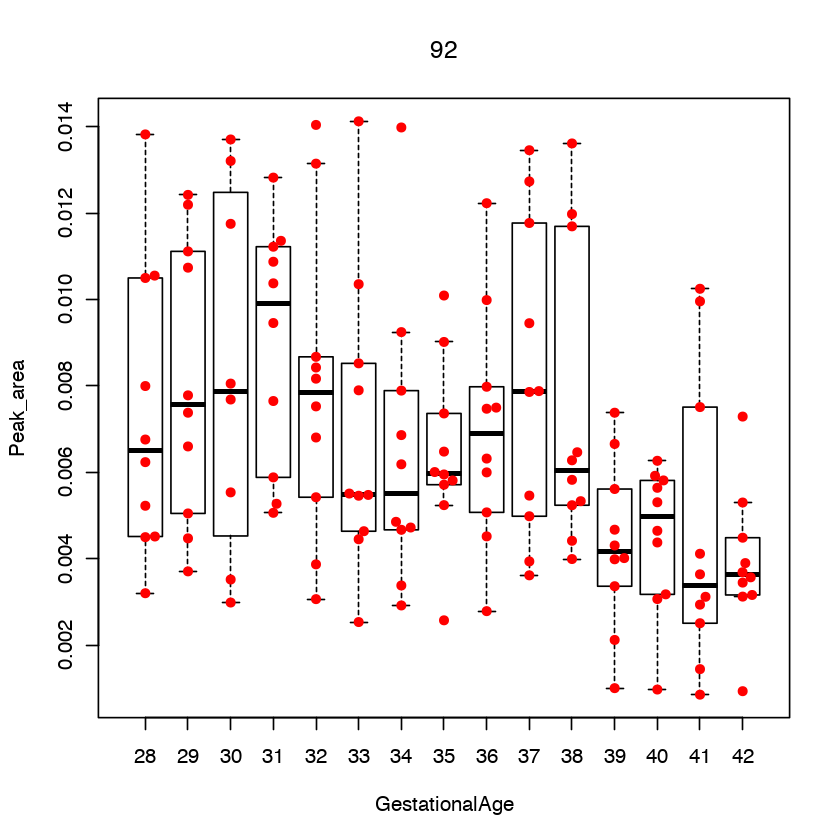

In [32]:
comp <- ftplot[,which(colnames(ftplot) == selid)]
    
df <- cbind(as.character(md$ATTRIBUTE_Gestationsalder[match(rownames(ftplot),md$filename)]),comp)
colnames(df) <- c('GestationalAge','Peak_area')
df <- as.data.frame(df)
df$GestationalAge <- as.numeric(as.character(df$GestationalAge))
df$Peak_area <- as.numeric(as.character(df$Peak_area))
    
boxplot(Peak_area ~ GestationalAge, data = df, outline = FALSE, main = selid)
beeswarm(Peak_area ~ GestationalAge, data = df, col = 2, pch = 16, add = TRUE)

plot all features with spectral library hit

In [33]:
selids <- colnames(ft[, which(colnames(ft) %in% rownames(sigs)[which(sigs[,5]!= 'NA')])])

In [34]:
selids
length(selids)

[1] "33"    "36"    "65"    "78"    "92"    "100"   "109"   "214"   "493"  
[10] "511"   "830"   "913"   "1093"  "2262"  "2396"  "2602"  "3082"  "3696" 
[19] "3749"  "4110"  "4580"  "4931"  "9473"  "9666"  "9812"  "9848"  "10001"
[28] "10635" "10897" "11066" "12284" "13729" "14019" "14969" "16983" "17174"
[37] "19209" "24510" "46209" "63633"

[1] 40

In [35]:
pdf("GA_KendallsTau_40Annotated_SupplementaryData1.pdf", height = 20, width = 20)
par(mfrow = c(5,5))
for (i in 1:length(selids)){
    selid <- selids[i]
    comp <- ftplot[,which(colnames(ftplot) == selid)]
    df <- cbind(as.character(md$ATTRIBUTE_Gestationsalder[match(rownames(ftplot),md$filename)]),comp)
    colnames(df) <- c('GestationalAge','Peak_area')
    df <- as.data.frame(df)
    df$GestationalAge <- as.numeric(as.character(df$GestationalAge))
    df$Peak_area <- as.numeric(as.character(df$Peak_area))

    boxplot(Peak_area ~ GestationalAge, data = df, outline = FALSE, main = selid)
    beeswarm(Peak_area ~ GestationalAge, data = df, col = 4, pch = 16, add = TRUE)
}
dev.off()

pdf 
  2